# 3-4. 深層学習の基礎と展望 - ディープニューラルネットワーク（DNN） / 3-6. 予測・判断 - ROC曲線、AUC（Area Under the Curve)
[メディア芸術データベースのデータ](https://github.com/mediaarts-db/dataset)を利用して，簡単な分類を行うディープニューラルネットワークのサンプルコードを見ていこう．

今回は，データベース上からゲームパッケージを取得し，「タイトル」「発行者」「ゲームプラットフォーム」を特徴量化して対象年齢（CERO）がいずれに該当するものなのかを予測する多クラス分類モデルを作っていく．

## データの取得・整形
[メディア芸術データベース・ラボ](https://mediag.bunka.go.jp/madb_lab/)上で提供されている[SPARQLクエリサービス](https://mediag.bunka.go.jp/madb_lab/lod/sparql/)を利用して，ゲームパッケージのデータを取得していく．

以下のコードを[SPARQLクエリサービス](https://mediag.bunka.go.jp/madb_lab/lod/sparql/)上に入力して実行する，または入力を省略した[こちらのURL](https://mediag.bunka.go.jp/madb_lab/lod/sparql/#query=PREFIX%20ma%3A%20%3Chttps%3A%2F%2Fmediaarts-db.bunka.go.jp%2Fdata%2Fproperty%23%3E%0APREFIX%20rdfs%3A%20%20%20%3Chttp%3A%2F%2Fwww.w3.org%2F2000%2F01%2Frdf-schema%23%3E%0APREFIX%20schema%3A%20%3Chttps%3A%2F%2Fschema.org%2F%3E%20SELECT%20%3F%E3%83%A9%E3%83%99%E3%83%AB%20%3F%E7%99%BA%E8%A1%8C%E8%80%85%20%3F%E3%83%97%E3%83%A9%E3%83%83%E3%83%88%E3%83%95%E3%82%A9%E3%83%BC%E3%83%A0%20%3F%E3%83%AC%E3%83%BC%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%20%3F%E5%85%AC%E9%96%8B%E5%B9%B4%E6%9C%88%E6%97%A5%0AWHERE%20%7B%0A%20%20%3F%E3%82%A2%E3%82%A4%E3%83%86%E3%83%A0%0A%20%20%20%20%20%20%20%20schema%3Agenre%20%22%E3%82%B2%E3%83%BC%E3%83%A0%E3%83%91%E3%83%83%E3%82%B1%E3%83%BC%E3%82%B8%22%3B%0A%20%20%20%20%20%20%20%20schema%3AcontentRating%20%3F%E3%83%AC%E3%83%BC%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%3B%0A%20%20%20%20%20%20%20%20schema%3AgamePlatform%20%3F%E3%83%97%E3%83%A9%E3%83%83%E3%83%88%E3%83%95%E3%82%A9%E3%83%BC%E3%83%A0%3B%0A%20%20%20%20%20%20%20%20schema%3Apublisher%20%3F%E7%99%BA%E8%A1%8C%E8%80%85%3B%0A%20%20%20%20%20%20%20%20rdfs%3Alabel%20%3F%E3%83%A9%E3%83%99%E3%83%AB%3B%0A%20%20%20%20%20%20%20%20ma%3AdatePublished%20%3F%E5%85%AC%E9%96%8B%E5%B9%B4%E6%9C%88%E6%97%A5.%0A%7D&endpoint=https%3A%2F%2Fmediag.bunka.go.jp%2Fsparql&requestMethod=POST&tabTitle=Query&headers=%7B%7D&contentTypeConstruct=application%2Fn-triples%2C*%2F*%3Bq%3D0.9&contentTypeSelect=application%2Fsparql-results%2Bjson%2C*%2F*%3Bq%3D0.9&outputFormat=table)から実行してデータを取得できる．

取得したCSVファイルを「ゲームパッケージ.csv」として保存し，このノートブック上にアップロードしよう．

※「3-4. 学習用データと学習済みモデル」，「3-6. 決定木」，「3-6. サポートベクターマシン」，「3-7. 形態素解析」，「3-7. かな漢字変換」，「3-7. 表現学習」と同じデータセットを作成するため，もし同じものを持っている場合は以下の取得作業は不要なので，そちらをアップロードしよう．

```
PREFIX ma: <https://mediaarts-db.bunka.go.jp/data/property#>
PREFIX rdfs:   <http://www.w3.org/2000/01/rdf-schema#>
PREFIX schema: <https://schema.org/> SELECT ?ラベル ?発行者 ?プラットフォーム ?レーティング ?公開年月日
WHERE {
  ?アイテム
        schema:genre "ゲームパッケージ";
        schema:contentRating ?レーティング;
        schema:gamePlatform ?プラットフォーム;
        schema:publisher ?発行者;
        rdfs:label ?ラベル;
        ma:datePublished ?公開年月日.
}
```

取得したデータセットを，Python上で扱いやすい形にしていく．
pandasというライブラリを用いて，csv形式のファイルの中身をDataFrameという型に変換し，扱っていく．

In [1]:
import pandas as pd

In [2]:
games = pd.read_csv("/content/ゲームパッケージ.csv")
games = games.drop_duplicates()
games = games.reset_index(drop=True)
games

ラベル  \
0                           Dance Dance Revolution GB2   
1                                     プロ野球 ファミスタ リターンズ   
2                                      プロ野球 ファミスタ 2011   
3                                              フロッガー3D   
4                                           ブレイブリーセカンド   
...                                                ...   
21976                 バイオショック インフィニット PlayStation Now版   
21977  バイオハザード リベレーションズ アンベールド エディション PlayStation Now版   
21978                           巫剣神威控 PlayStation Now版   
21979                 ネバーエンディング ナイトメア PlayStation Now版   
21980                   雷電IV OverKill PlayStation Now版   

                           発行者       プラットフォーム            レーティング       公開年月日  
0                      コナミ株式会社         ゲームボーイ  CERO D (17才以上対象)  2000-11-16  
1        株式会社バンダイナムコエンターテインメント      ニンテンドー3DS    CERO A (全年齢対象)  2015-10-08  
2              株式会社バンダイナムコゲームス      ニンテンドー3DS    CERO A (全年齢対象)  2011-03-31  
3         株式会社コナミデジタルエンタテインメント      ニンテンドー3DS    CERO A (全年齢対象)  2011-09-22  
4              株式会社スクウェア・エニックス      ニンテンドー3DS  CERO C (15才以上対象)  2015-04-23  
...                        ...            ...               ...         ...  
21976  テイクツー・インタラクティブ・ジャパン合同会社  プレイステーション Now  CERO D (17才以上対象)  2017-09-19  
21977                 株式会社カプコン  プレイステーション Now  CERO D (17才以上対象)  2016-09-20  
21978           アクティブゲーミングメディア  プレイステーション Now  CERO C (15才以上対象)  2017-07-20  
21979           アクティブゲーミングメディア  プレイステーション Now  CERO D (17才以上対象)  2017-07-20  
21980                       モス  プレイステーション Now    CERO A (全年齢対象)  2017-02-21  

[21981 rows x 5 columns]

まず，前処理前のデータの取得したgamesの["レーティング"]カラム（対象年齢を表す列）には，どんなものがいくつ含まれているか見てみよう．


In [3]:
import collections

In [4]:
collections.Counter(games["レーティング"]) #games["レーティング"]内に何がどれだけあるか数える

Counter({'CERO D (17才以上対象)': 1966,
         'CERO A (全年齢対象)': 9232,
         'CERO C (15才以上対象)': 3237,
         'CERO B (12才以上対象)': 4706,
         'CERO Z (18才以上のみ対象)': 752,
         'IARC 16+': 2,
         'IARC 12+': 4,
         'IARC 3+': 4,
         'CERO 全年齢': 852,
         'CERO 12': 131,
         'CERO 15': 85,
         'CERO 18': 41,
         '推奨年齢 全年齢': 610,
         '推奨年齢 18才以上': 50,
         'X指定 18才以上': 25,
         '推奨年齢 年齢制限 18才以上': 29,
         'ESRB E': 3,
         'PG': 1,
         '18': 4,
         '審査済証 映像倫理機構 ETHICS 成人指定 18歳未満販売・貸出禁止': 12,
         'ELSPA 3+': 1,
         'ESRB T': 7,
         'ESRB M': 4,
         'EOCS 審査済 一般ソフトウェア General Softwere 15歳以上推奨 (コンピュータソフトウェア倫理機構)': 4,
         '18才未満お断り (コンピュータソフトウェア倫理機構)': 112,
         'EOCS 審査済 (コンピュータソフトウェア倫理機構)': 26,
         'EOCS 審査済 一般ソフトウェア General Softwere 12歳以上推奨 (コンピュータソフトウェア倫理機構)': 3,
         '18+': 1,
         '12+': 5,
         'USK 16': 1,
         '一般 (15歳以上推奨)': 4,
         '3+': 5,
         '3': 1,


想定よりもさまざまなデータが混在している．特に，CERO+[英字]のものとCERO+[数字or日本語]のものはそれぞれ対象がかぶっていそうなデータであるため扱いが難しそうだ．

これについて
[CEROの公式サイト](https://www.cero.gr.jp/publics/index/17/)によれば，


> 年齢区分マーク （平成18年3月1日改訂）

とのことだったので，今回は2006年以降の新レーティングである「CERO　A/B/C/D/Z」のみを対象として分類を行なっていくこととする．

`games`に取得していたデータの中から，「CERO A/B/C/D/Z」のデータのみを取得して新たに`games`に保存していく．

In [5]:
games = games.query(
    "レーティング == 'CERO A (全年齢対象)' or レーティング == 'CERO B (12才以上対象)' or レーティング == 'CERO C (15才以上対象)' or レーティング ==  'CERO D (17才以上対象)' or レーティング == 'CERO Z (18才以上のみ対象)'"
)

データは揃ったが，このままタイトルや発行者などの文字列をDNNモデルに直接入力することはできない．

そこで，今回特徴量にする情報群をベクトル化していく．

In [6]:
# 必要なモジュールの読み込み
!pip install mecab-python3
!pip install unidic-lite
import MeCab

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658817 sha256=ab32972735ac2439c55e4ca68fe966055a2b4391fee9d44d22912479b0685e90
  Stored in directory: /root/.cache/pip/wheels/89/e8/68/f9ac36b8cc6c8b3c96888cd57434abed96595d444f42243853
Successfully built unidic-lite


### タイトルのベクトル化
文章を単語に分かち書きし，それら単語の出現の有無を0,1ビットで表現するベクトルに変換する手法を取ることにする．

In [7]:
# 分かち書きを行うインスタンスwakatiの作成
wakati = MeCab.Tagger('-Owakati')

# 分かち書きしたタイトルを格納するリスト
wakati_titles = []

for title in games['ラベル']:
  wakati_titles.append(wakati.parse(title).strip())

# 文字列->ベクトルを変換するインスタンスの作成・学習
tokenizer = Tokenizer()
tokenizer.fit_on_texts(wakati_titles)

# どの単語がタイトル内に現れているか？を0,1で表すベクトルに変換し，labelsに格納
labels = tokenizer.texts_to_matrix(wakati_titles, mode="binary")


### 発行者のベクトル化
各会社をカテゴリ変数と見做し，one-hotベクトル表現によってこれを表すことにする．

In [8]:
# ワンホットベクトルへのエンコードを行うインスタンスonehot_encoderの作成
onehot_encoder = OneHotEncoder(sparse = False,dtype = int)

# 発行者がどこか？を表すワンホットベクトルへの学習・変換を同時に行う関数．変換後はcreatorsに格納
creators = onehot_encoder.fit_transform(np.array(games['発行者']).reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### プラットフォームのベクトル化
発行者の時と同様，各プラットフォームをカテゴリ変数と見做し，one-hotベクトル表現によってこれを表すことにする．

In [9]:
# プラットフォームが何か？を表すワンホットベクトルへの学習・変換を同時に行う関数．変換後はplatformsに格納
platforms = onehot_encoder.fit_transform(np.array(games['プラットフォーム']).reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### 特徴量ベクトルの作成


In [10]:
# 各特徴量を横並びに結合して，1つのゲームパッケージにつき1つの結合された特徴量ベクトルが対応するようにする
X = np.concatenate([labels, creators,platforms], axis=1)
print(f"データの数：　{X.shape[0]}, 1つのデータを表す特徴量ベクトルの次元数: {X.shape[1]}")

データの数：　19893, 1つのデータを表す特徴量ベクトルの次元数: 13606


### 正解ラベル（対象年齢）のベクトル化
こちらも今まで同様，各対象年齢をカテゴリ変数と見做し，one-hotベクトル表現によってこれを表すことにする．

In [11]:
y = onehot_encoder.fit_transform(np.array(games['レーティング']).reshape(-1,1))
print(f"データの数: {y.shape[0]}, 正解ベクトルの次元数: {y.shape[1]}")

データの数: 19893, 正解ベクトルの次元数: 5


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


上記の特徴量ベクトルに対応する5次元の正解ベクトルが作成された．

### 学習データとテストデータに分ける

In [12]:
# デフォルトでは学習データは75%，テストデータは25%になる
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), shuffle=True)

## ディープニューラルネットワーク（DNN）
上記で用意したデータセットを利用して，
「全結合層」「活性化層」「ドロップアウト層」のみを用いた簡単な多クラス分類モデルを作っていく．
（モデルの学習には10分ほどかかるので注意）

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

In [14]:
# モデルの構築
model = Sequential()
model.add(Dense(256, input_shape=(len(X_train[0]),))) #256次元の全結合層
model.add(Activation('relu')) #活性化
model.add(Dropout(0.2)) #ドロップアウト
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(len(y_train[0])))# 出力層の次元数は，正解データの次元数（=5次元）に合わせる
model.add(Activation('softmax'))

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

# 学習
model.fit(X_train, y_train, validation_split=0.1, epochs=10, batch_size=256)

# 評価
result = model.evaluate(X_test, y_test)
print(f"Testデータに対するLoss: {result[0]}, Testデータに対するAccuracy: {result[1]}")

Epoch 1/10
53/53 [==============================] - 8s 137ms/step - loss: 1.1553 - accuracy: 0.5560 - val_loss: 0.7959 - val_accuracy: 0.7078
Epoch 2/10
53/53 [==============================] - 6s 108ms/step - loss: 0.5372 - accuracy: 0.8230 - val_loss: 0.5181 - val_accuracy: 0.8204
Epoch 3/10
53/53 [==============================] - 6s 122ms/step - loss: 0.2393 - accuracy: 0.9302 - val_loss: 0.4493 - val_accuracy: 0.8458
Epoch 4/10
53/53 [==============================] - 6s 104ms/step - loss: 0.1221 - accuracy: 0.9660 - val_loss: 0.4401 - val_accuracy: 0.8499
Epoch 5/10
53/53 [==============================] - 6s 121ms/step - loss: 0.0740 - accuracy: 0.9810 - val_loss: 0.4597 - val_accuracy: 0.8586
Epoch 6/10
53/53 [==============================] - 6s 106ms/step - loss: 0.0489 - accuracy: 0.9870 - val_loss: 0.4880 - val_accuracy: 0.8539
Epoch 7/10
53/53 [==============================] - 6s 121ms/step - loss: 0.0375 - accuracy: 0.9899 - val_loss: 0.5107 - val_accuracy: 0.8552
Epoch 

# 3-6. 予測・判断 - ROC曲線、AUC（Area Under the Curve）

ROC曲線とは偽陽性率(=1−Specificity)を横軸，再現率（Recall）を縦軸にとって陽性/陰性の判断基準を変えたときの変化を表す曲線のことである．
また，AUCとはROC曲線とx軸の間の⾯積で，値が1に近いほど予測モデルの性能が⾼いと判断できるものである（ランダムな分類モデルの場合，ROC曲線は直線y=xに近づき，AUCの値は0.5程度になる）．


多クラス分類問題においてもAUCの計算およびROC曲線のプロットができるが，陽性/陰性の判断の仕方や平均の仕方を工夫する必要がある．いくつか方法はあるが，以下に2つ例を挙げる．
1. マクロ平均
    * クラスごとにROC曲線を描き，それぞれに対してAUCを計算した後で単純な平均を取る
    * クラスごとに属する要素の個数によらず，すべてのクラスの結果を平等に反映させたい場合こちらが適している
    1. One vs Rest（OvR）
        * ある特定のクラスを正解としたとき，その他のクラス全てを不正解とみなす
        * ROC曲線は1つのクラスにつき1つ描くことができる

    1. One vs One（OvO）
        * ある特定のクラスを正解としたとき，その他のクラス全てとの組み合わせでペアを作り，個々のペアに対してROC曲線を描く
        * ROC曲線はペアの作り方*2通り描くことができる

1. マイクロ平均
    * クラスごとの「実際に陽性のデータを陽性と予測できた数（TP）」と「実際は陰性のデータを陽性と誤予測した数（FP）」を合算してモデルのTP，FPとすることで1つのROCを描き，AUCを計算する
    * 要素数が少ないクラスの重要度が低い場合こちらが適している


今回はマイクロ平均を採用することとする．

In [15]:
# 必要なモジュールのインポート
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

In [16]:
# 予測データを用意
y_pred = model.predict(X_test)

# 形を確認
y_pred.shape

156/156 [==============================] - 1s 8ms/step


(4974, 5)

In [17]:
# 予測データを一次元に平坦化
y_pred_ravel = y_pred.ravel()
print(y_pred_ravel.shape)

# 正解データも平坦化
y_test_ravel = y_test.ravel()
print(y_test_ravel.shape)

(24870,)
(24870,)


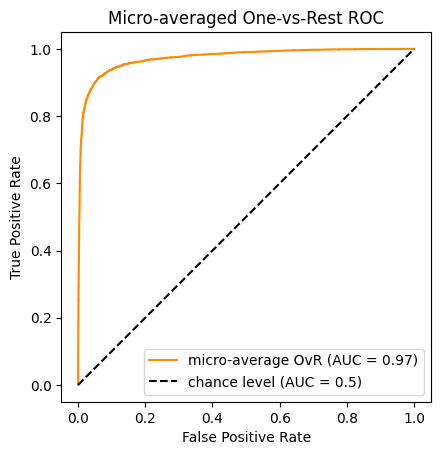

In [18]:
# ROC曲線のプロット
RocCurveDisplay.from_predictions(
    y_test_ravel,
    y_pred_ravel,
    name="micro-average OvR",
    color="darkorange",
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest ROC")
plt.legend()
plt.show()

In [19]:
# AUCの値はROC曲線のプロットにも記載されるが，計算のみであればはこちらでもできる
micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_pred,
    multi_class="ovr",
    average="micro",
)

print(f"Micro-averaged One-vs-Rest ROC AUC score: {micro_roc_auc_ovr:.2f}")


Micro-averaged One-vs-Rest ROC AUC score: 0.97


AUCの値から見ても，かなり精度のいい分類モデルができたと言える．